# Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import compute_status, balance_classes_with_oversampling

In [2]:
# Load the data (.xlsx file)
path_data_SPARE = "data/Etude SPARE 200 échantillons, 230 peptides et 75 protéines.xlsx"
df_SPARE = pd.read_excel(path_data_SPARE, sheet_name='Final')

path_data_PREDIMID = "data/Etude PREDIMID 58 échantillons et 230 peptides et 75 protéines.xlsx"
df_PREMIDID = pd.read_excel(path_data_PREDIMID, sheet_name='Final')

path_unique = "data/Liste des peptides unique.xlsx"
df_unique = pd.read_excel(path_unique)

# Functions

## Plot functions

In [3]:
def plot_corr_distribution(curve1, curve2, curve3, curve4):
    """
    Plot the distribution of Spearman correlation values for four different peptide datasets.

    Parameters:
        curve1 (list or array-like): Correlation values for Light SPARE peptides.
        curve2 (list or array-like): Correlation values for Heavy SPARE peptides.
        curve3 (list or array-like): Correlation values for Light PREMIDID peptides.
        curve4 (list or array-like): Correlation values for Heavy PREMIDID peptides.

    Returns:
        None
    """
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot each histogram with appropriate style and label
    plt.hist(curve1, bins=25, density=True, label='Light SPARE', alpha=0.7, color='blue', ec='black')
    plt.hist(curve2, bins=25, density=True, label='Heavy SPARE', alpha=0.2, color='red', ec='black')
    plt.hist(curve3, bins=25, density=True, label='Light PREMIDID', alpha=0.7, color='green', ec='black')
    plt.hist(curve4, bins=25, density=True, label='Heavy PREMIDID', alpha=0.2, color='purple', ec='black')

    # Add title and axis labels
    plt.title('Correlation Distributions', fontsize=16)
    plt.xlabel('Correlation Values', fontsize=14)
    plt.ylabel('Density', fontsize=14)

    # Add legend to explain the curves
    plt.legend(fontsize=12, loc='upper left')

    # Add grid for better readability
    plt.grid(alpha=0.3)

    # Show the plot
    plt.show()


def plot_peptide_signal(data, replicate_number, list_of_arrays,
                        peptide_name="PrecursorIonNamelight", SPARE=True, title=""):
    """
    Plot the peptide signal intensity across replicates for a given protein.

    Parameters:
        data (pd.DataFrame): Filtered DataFrame for the target protein.
        replicate_number (array-like): List of replicate IDs (x-axis).
        list_of_arrays (list): List of intensity values (one per peptide).
        peptide_name (str): Column name for peptide identifiers.
        SPARE (bool): Whether the dataset is SPARE (used for labeling).
        title (str): Plot title.

    Returns:
        None (saves the plot as a PNG file).
    """
    print("SPARE" if SPARE else "PREMIDID")
    
    plt.figure(figsize=(30, 8))

    # Plot each peptide's intensity curve
    for i, pept_name in enumerate(data[peptide_name].unique()):
        plt.plot(replicate_number, list_of_arrays[i], label=pept_name, marker='o')

    # Customize x-axis (rotate labels, show every 3rd tick)
    plt.xticks(replicate_number[::3], rotation=90)
    plt.ylim(bottom=0)
    plt.xlabel("Replicate", fontsize=17, labelpad=15)
    plt.ylabel("Peak area", fontsize=17)
    plt.legend(fontsize=15)
    plt.title(title, fontsize=25, pad=15)

    # Clean title for filename
    title = title.replace(" ", "_").replace(":", "").replace("|", "_")
    title = f"SPARE_{title}" if SPARE else f"PREMIDID_{title}"

    # Save the figure
    plt.savefig(f"Images/PeptideSignals/{title}.png", format='png', bbox_inches='tight')
    plt.close()


def plot_correlation(corr_matrix, title, SPARE=True):
    """
    Display and save the correlation matrix between peptides as a table.

    Parameters:
        corr_matrix (pd.DataFrame): The correlation matrix (e.g., Spearman).
        title (str): Title for the plot (also used in the filename).
        SPARE (bool): Indicates whether the dataset is SPARE.

    Returns:
        None (saves the table as a PNG file).
    """
    fig, ax = plt.subplots(figsize=(8, 2))

    # Hide axes for a cleaner table display
    ax.axis("tight")
    ax.axis("off")

    # Create a table from the correlation matrix
    table = ax.table(
        cellText=np.round(corr_matrix.values, 5),
        colLabels=corr_matrix.columns,
        rowLabels=corr_matrix.index,
        cellLoc="center",
        loc="center",
        bbox=[0, 0, 1, 0.8]
    )

    # Format header cells
    for key, cell in table._cells.items():
        cell.set_fontsize(12)
        if key[0] == 0 or key[1] == -1:
            cell.set_text_props(weight='bold')

    # Finalize title and layout
    plt.title(title, fontsize=16)
    plt.subplots_adjust(top=0.8)

    # Clean title for filename
    title = title.replace(" ", "_").replace(":", "").replace("|", "_")

    # Save figure
    plt.savefig(f"Images/CorrelationMatrix/{'SPARE' if SPARE else 'PREMIDID'}_{title}.png", format='png', bbox_inches='tight')
    plt.close()

## Utils functions

In [4]:
def process_file(path_file, df_unique, sheet_name='Final', threshold=0.7,
                 protein_name="ProteinName", total_area_name="TotalArea_light(raw_data)",
                 peptide_name="PrecursorIonNamelight", verbose=True, comp_status=False):
    """
    Process and optionally analyze a peptide-protein dataset from an Excel file.

    Parameters:
        path_file (str): Path to the Excel file containing the data.
        df_unique (pd.DataFrame): DataFrame containing the column "Peptide sequences" for filtering.
        sheet_name (str): Name of the Excel sheet to load (default is 'Final').
        threshold (float): Correlation threshold used for status computation if comp_status=True.
        protein_name (str): Column name containing protein identifiers.
        total_area_name (str): Column name containing intensity values (used only if comp_status=True).
        peptide_name (str): Column name containing peptide identifiers.
        verbose (bool): Whether to print intermediate information.
        comp_status (bool): Whether to compute peptide status based on correlation.

    Returns:
        pd.DataFrame: 
            - If comp_status is False: filtered dataset.
            - If comp_status is True: peptide status per protein (with columns "ProteinName", "Peptide", "Status").
    """
    # Load the Excel file
    df = pd.read_excel(path_file, sheet_name=sheet_name)

    # Work on a copy to avoid modifying original data
    copy_df = df.copy()

    # Initial peptide count
    if verbose:
        print(f"Initially, we have {len(copy_df[peptide_name].unique())} peptides")

    # Clean peptide names (remove 'pep_' prefix and bracketed info)
    copy_df[peptide_name] = copy_df[peptide_name].str.replace(r'^pep_|\[.*?\]', '', regex=True)

    # Keep only peptides present in the unique peptide list
    copy_df = copy_df[copy_df[peptide_name].isin(df_unique["Peptide sequences"])]

    if verbose:
        print(f"Then, we have {len(copy_df[peptide_name].unique())} peptides after removing the non-unique peptides")

    # Remove proteins with only one associated peptide
    tmp_df = copy_df.groupby(protein_name)[peptide_name].nunique().reset_index(name="Peptide count")
    protein_with_multiple_peptide = tmp_df[tmp_df["Peptide count"] > 1]
    copy_df = copy_df[copy_df[protein_name].isin(protein_with_multiple_peptide[protein_name])]

    if verbose:
        print(f"Finally, we have {len(copy_df[peptide_name].unique())} peptides after removing the proteins with only one peptide\n")

    # compute peptide status based on correlation
    if comp_status:
        return compute_status(copy_df, threshold,
                              protein_name=protein_name,
                              total_area_name=total_area_name,
                              peptide_name=peptide_name)
    else:
        return copy_df

def compute_corr_distribution(dataframe, indices):
    """
    Compute the distribution of pairwise Spearman correlations between peptides for each protein.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing protein, peptide, and intensity data.
        indices (tuple): A tuple of three integers representing the column indices:
                        - Protein column index
                        - Peptide column index
                        - Intensity/TotalArea column index

    Returns:
        list: A list of Spearman correlation values between peptide pairs across all proteins.
    """
    columns_name = dataframe.columns

    # Unpack the column indices
    Prot_idx, Pept_idx, Total_area_idx = indices

    # Get the list of unique proteins
    Prot_names = dataframe[columns_name[Prot_idx]].unique()

    corr_values = []

    # Iterate over each protein
    for i, prot in enumerate(Prot_names):
        # Filter rows corresponding to the current protein
        tmp_data = dataframe[dataframe[columns_name[Prot_idx]] == prot]

        list_of_arrays = []

        # For each peptide of the current protein, collect the intensity values
        for j, pept in enumerate(tmp_data[columns_name[Pept_idx]].unique()):
            tmp_data_pept = tmp_data[tmp_data[columns_name[Pept_idx]] == pept]
            total_area = tmp_data_pept[columns_name[Total_area_idx]]
            list_of_arrays.append(total_area)

        # Create a DataFrame where each column corresponds to one peptide's intensity values
        Pept_name = tmp_data[columns_name[Pept_idx]].unique()
        df = pd.DataFrame()

        for j, array in enumerate(list_of_arrays):
            tmp_array = np.array(array)
            df[f"{Pept_name[j]}"] = tmp_array

        # Compute the Spearman correlation matrix between peptide columns
        corr = np.array(df.corr(method='spearman'))

        # Extract upper triangle values (excluding the diagonal)
        values = corr[np.triu_indices(corr.shape[0], k=1)]

        # Add these values to the global list
        corr_values.extend(values)

    return corr_values

def process_data(data, prot_target, threshold=0.7, protein_name="ProteinName",
                 total_area_name="TotalArea_light(raw_data)", peptide_name="PrecursorIonNamelight",
                 SPARE=True):
    """
    Process peptide signal data for a given protein: filters data, plots peptide signals, and computes correlation.

    Parameters:
        data (pd.DataFrame): The input dataset containing protein, peptide, and intensity information.
        prot_target (str): The name/identifier of the protein to isolate and analyze.
        threshold (float): Unused in this function, placeholder for consistency.
        protein_name (str): Name of the column containing protein identifiers.
        total_area_name (str): Name of the column containing intensity values (e.g., Total Area).
        peptide_name (str): Name of the column containing peptide identifiers.
        SPARE (bool): Indicates whether the dataset comes from SPARE (used for filename labeling).

    Returns:
        tuple: Filtered DataFrame, list of replicate identifiers, and list of intensity arrays (one per peptide).
    """
    # Copy and filter the dataset for the selected protein
    copy_data = data.copy()
    copy_data = copy_data[copy_data[protein_name] == prot_target]

    # Clean peptide names (remove prefix like "pep_")
    copy_data[peptide_name] = copy_data[peptide_name].str.replace(r'^pep_', '', regex=True)

    # Build a list of intensity arrays for each peptide
    list_of_arrays = []
    for i, pept_name in enumerate(copy_data[peptide_name].unique()):
        total_area_light = copy_data[copy_data[peptide_name] == pept_name][total_area_name]
        list_of_arrays.append(total_area_light)

    # Get replicate identifiers
    replicate_number = copy_data["Replicate"].unique()

    # Plot signal curves and correlation matrix
    plot_peptide_signal(copy_data, replicate_number, list_of_arrays,
                        peptide_name=peptide_name, SPARE=SPARE,
                        title=f"Peptide signals for Protein: {prot_target}")
    process_data_correlation(copy_data, list_of_arrays,
                             peptide_name=peptide_name,
                             title=f"Correlation matrix for Protein: {prot_target}", SPARE=SPARE)

    return copy_data, replicate_number, list_of_arrays

def process_data_correlation(data, list_of_arrays, peptide_name="PrecursorIonNamelight", title="", SPARE=True):
    """
    Create a DataFrame from peptide intensity arrays and compute the Spearman correlation matrix.

    Parameters:
        data (pd.DataFrame): The filtered data for the protein.
        list_of_arrays (list): List of intensity arrays (one per peptide).
        peptide_name (str): Column name for peptide identifiers.
        title (str): Title for the correlation matrix plot.
        SPARE (bool): Indicates whether the dataset is SPARE.

    Returns:
        pd.DataFrame: The computed correlation matrix (Spearman).
    """
    peptide_names = data[peptide_name].unique()

    # Build a DataFrame with peptide intensities as columns
    df = pd.DataFrame()
    for i, array in enumerate(list_of_arrays):
        df[f"{peptide_names[i]}"] = np.array(array)

    # Compute correlation matrix
    correlation = df.corr(method='spearman')

    # Plot and save the correlation matrix
    plot_correlation(correlation, title, SPARE=SPARE)    

    return correlation

# Experiment on the behaviour of the dataset with different threshold

In [5]:
# Experiment on the behaviour of the dataset with different threshold 
thresholds = np.arange(0.7, 0.95, 0.01)
percentages_SPARE = []
lengths_SPARE = []
for threshold in thresholds:
    threshold = round(threshold, 2)
    final_status_SPARE = process_file(path_data_SPARE, df_unique, threshold=threshold, verbose=False, comp_status=True)
    final_status_SPARE.columns = [f"{col}_SPARE" for col in final_status_SPARE.columns]
    
    print(f"SPARE ({threshold}):")
    print(f"Il y a {final_status_SPARE[final_status_SPARE['Status_SPARE'] == 'bon'].shape[0]} peptides de bon status (quantotypic).")
    print(f"Il y a {final_status_SPARE[final_status_SPARE['Status_SPARE'] == 'mauvais'].shape[0]} peptides de mauvais status (non-quantotypic).")
    print()
    percentage = final_status_SPARE[final_status_SPARE['Status_SPARE'] == 'bon'].shape[0] / final_status_SPARE.shape[0]
    percentages_SPARE.append(percentage)
    lengths_SPARE.append(final_status_SPARE.shape[0])

SPARE (0.7):
Il y a 191 peptides de bon status (quantotypic).
Il y a 8 peptides de mauvais status (non-quantotypic).

SPARE (0.71):
Il y a 190 peptides de bon status (quantotypic).
Il y a 9 peptides de mauvais status (non-quantotypic).

SPARE (0.72):
Il y a 187 peptides de bon status (quantotypic).
Il y a 10 peptides de mauvais status (non-quantotypic).

SPARE (0.73):
Il y a 187 peptides de bon status (quantotypic).
Il y a 10 peptides de mauvais status (non-quantotypic).

SPARE (0.74):
Il y a 182 peptides de bon status (quantotypic).
Il y a 12 peptides de mauvais status (non-quantotypic).

SPARE (0.75):
Il y a 179 peptides de bon status (quantotypic).
Il y a 12 peptides de mauvais status (non-quantotypic).

SPARE (0.76):
Il y a 177 peptides de bon status (quantotypic).
Il y a 14 peptides de mauvais status (non-quantotypic).

SPARE (0.77):
Il y a 175 peptides de bon status (quantotypic).
Il y a 16 peptides de mauvais status (non-quantotypic).

SPARE (0.78):
Il y a 175 peptides de bon st

In [6]:
# Experiment on the behaviour of the dataset with different threshold 
thresholds = np.arange(0.7, 0.95, 0.01)
percentages_PREDIMID = []
lengths_PREDIMID = []
for threshold in thresholds:
    threshold = round(threshold, 2)
    final_status_PREDIMID = process_file(path_data_PREDIMID, df_unique, threshold=threshold, protein_name="Protein Name", total_area_name="Total Area", peptide_name="Precursor Ion Name", verbose=False, comp_status=True)
    final_status_PREDIMID.columns = [f"{col}_PREDIMID" for col in final_status_PREDIMID.columns]
    
    print(f"PREDIMID ({threshold}):")
    print(f"Il y a {final_status_PREDIMID[final_status_PREDIMID['Status_PREDIMID'] == 'bon'].shape[0]} peptides de bon status (quantotypic).")
    print(f"Il y a {final_status_PREDIMID[final_status_PREDIMID['Status_PREDIMID'] == 'mauvais'].shape[0]} peptides de mauvais status (non-quantotypic).")
    print()
    percentage = final_status_PREDIMID[final_status_PREDIMID['Status_PREDIMID'] == 'bon'].shape[0] / final_status_PREDIMID.shape[0]
    percentages_PREDIMID.append(percentage)
    lengths_PREDIMID.append(final_status_PREDIMID.shape[0])

PREDIMID (0.7):
Il y a 198 peptides de bon status (quantotypic).
Il y a 6 peptides de mauvais status (non-quantotypic).

PREDIMID (0.71):
Il y a 198 peptides de bon status (quantotypic).
Il y a 6 peptides de mauvais status (non-quantotypic).

PREDIMID (0.72):
Il y a 197 peptides de bon status (quantotypic).
Il y a 7 peptides de mauvais status (non-quantotypic).

PREDIMID (0.73):
Il y a 196 peptides de bon status (quantotypic).
Il y a 8 peptides de mauvais status (non-quantotypic).

PREDIMID (0.74):
Il y a 192 peptides de bon status (quantotypic).
Il y a 7 peptides de mauvais status (non-quantotypic).

PREDIMID (0.75):
Il y a 191 peptides de bon status (quantotypic).
Il y a 8 peptides de mauvais status (non-quantotypic).

PREDIMID (0.76):
Il y a 188 peptides de bon status (quantotypic).
Il y a 11 peptides de mauvais status (non-quantotypic).

PREDIMID (0.77):
Il y a 185 peptides de bon status (quantotypic).
Il y a 12 peptides de mauvais status (non-quantotypic).

PREDIMID (0.78):
Il y a

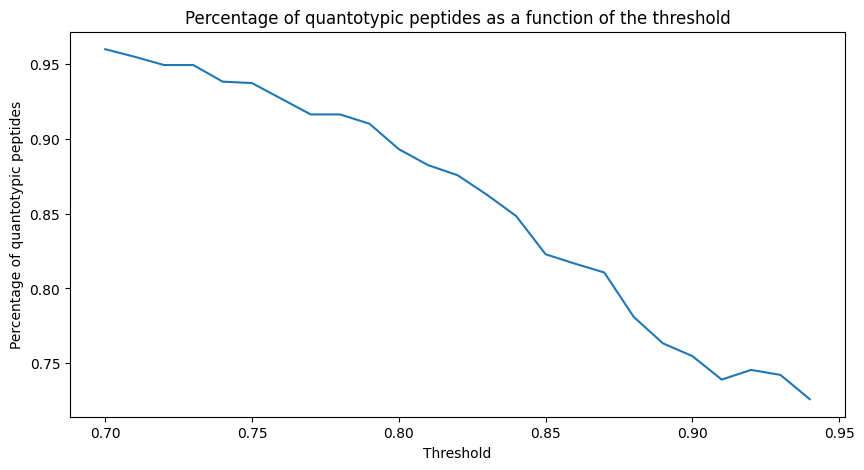

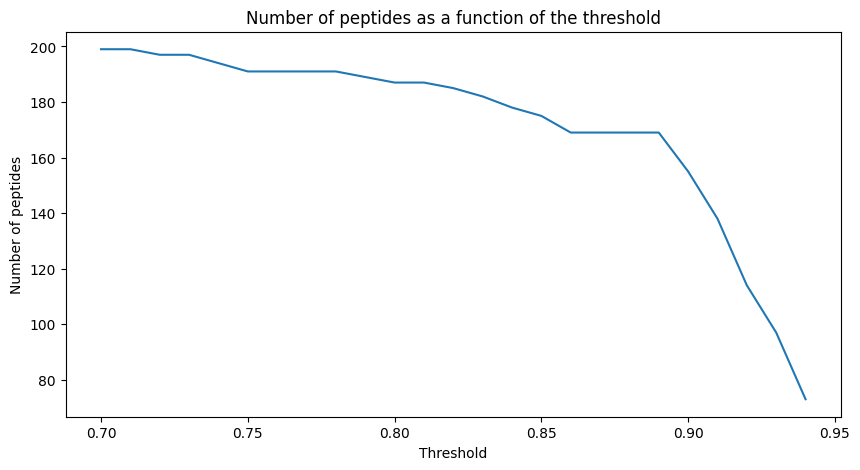

In [7]:
plt.figure(figsize=(10, 5))

plt.plot(thresholds, percentages_SPARE, label="SPARE")
# plt.plot(thresholds, percentages_PREDIMID, label="PREDIMID")

plt.xlabel("Threshold")
plt.ylabel("Percentage of quantotypic peptides")
plt.title("Percentage of quantotypic peptides as a function of the threshold")
plt.savefig(f"Images/percentage_quantotypic_peptides_threshold.png")
plt.show()

plt.figure(figsize=(10, 5))

plt.plot(thresholds, lengths_SPARE, label="SPARE")
# plt.plot(thresholds, lengths_PREDIMID, label="PREDIMID")

plt.xlabel("Threshold")
plt.ylabel("Number of peptides")
plt.title("Number of peptides as a function of the threshold")
plt.savefig(f"Images/number_peptides_threshold.png")
plt.show()

# Compute SPARE quantotypic vs non-quantotypic distribution

In [8]:
# Load the data (.xlsx file)
path_data_SPARE_UNIQUE = "data/df_SPARE_UNIQUE.xlsx"
final_status_SPARE = process_file(path_data_SPARE, df_unique, threshold=0.9, verbose=True, comp_status=True)
final_status_SPARE.columns = [f"{col}_SPARE" for col in final_status_SPARE.columns]
final_status_SPARE

Initially, we have 230 peptides
Then, we have 213 peptides after removing the non-unique peptides
Finally, we have 206 peptides after removing the proteins with only one peptide



,ProteinName_SPARE,Peptide_SPARE,Status_SPARE
0,sp|P02751|FINC_HUMAN,VDVIPVNLPGEHGQR,bon
1,sp|P02751|FINC_HUMAN,STTPDITGYR,bon
2,sp|P02751|FINC_HUMAN,SYTITGLQPGTDYK,bon
3,sp|P02751|FINC_HUMAN,IYLYTLNDNAR,bon
4,sp|P04114|APOB_HUMAN,TGISPLALIK,bon
...,...,...,...
150,sp|P02743|SAMP_HUMAN,VGEYSLYIGR,bon
151,sp|P04004|VTNC_HUMAN,GQYCYELDEK,mauvais
152,sp|P04004|VTNC_HUMAN,FEDGVLDPDYPR,bon
153,sp|P04004|VTNC_HUMAN,DWHGVPGQVDAAMAGR,bon


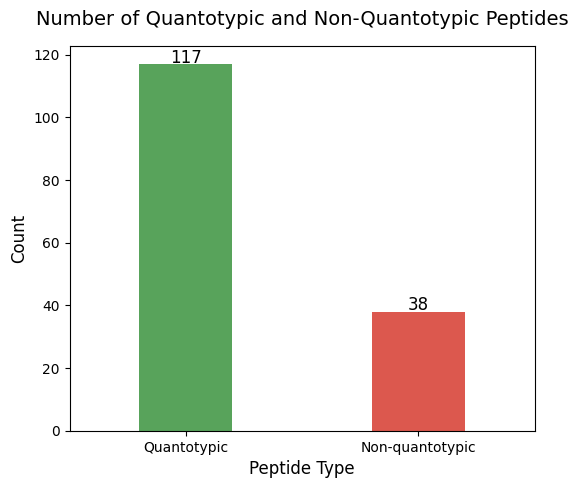

In [11]:
# Create a copy of the final status DataFrame
oversampled_df = final_status_SPARE.copy()

# Map "bon" to 0 and "mauvais" to 1 for binary classification
oversampled_df["quantotypic"] = oversampled_df["Status_SPARE"].map({"bon": 0, "mauvais": 1})

# Copy the oversampled data
data = oversampled_df.copy()

# Map 0 -> "Quantotypic" and 1 -> "Non-quantotypic" for better visualization
data["quantotypic"] = data["quantotypic"].map({0: "Quantotypic", 1: "Non-quantotypic"})

# Count the number of occurrences in each class
count_data = data["quantotypic"].value_counts()

# Create the bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=count_data.index, y=count_data.values, hue=count_data.index, 
            palette=["#4CAF50", "#F44336"], width=0.4, legend=False)

# Set axis labels and title
plt.xlabel("Peptide Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Quantotypic and Non-Quantotypic Peptides", fontsize=14, pad=15)

# Add value labels on top of each bar
for i, v in enumerate(count_data.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

# Save and show the figure
plt.savefig("Images/number_quantotypic_non_quantotypic_peptides.png", bbox_inches='tight')
plt.show()

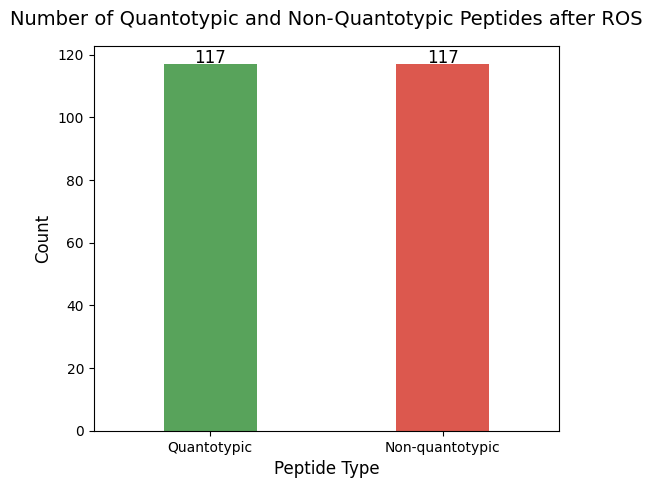

In [10]:
# Create a copy of the final status DataFrame
oversampled_df = final_status_SPARE.copy()

# Map "bon" to 0 and "mauvais" to 1 for binary classification
oversampled_df["quantotypic"] = oversampled_df["Status_SPARE"].map({"bon": 0, "mauvais": 1})

# Apply RandomOverSampler to balance the classes
oversampled_df = balance_classes_with_oversampling(oversampled_df, "Peptide_SPARE")

# Copy the oversampled data
data = oversampled_df.copy()

# Map 0 -> "Quantotypic" and 1 -> "Non-quantotypic" for better visualization
data["quantotypic"] = data["quantotypic"].map({0: "Quantotypic", 1: "Non-quantotypic"})

# Count the number of occurrences in each class
count_data = data["quantotypic"].value_counts()

# Create the bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=count_data.index, y=count_data.values, hue=count_data.index, 
            palette=["#4CAF50", "#F44336"], width=0.4, legend=False)

# Set axis labels and title
plt.xlabel("Peptide Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Quantotypic and Non-Quantotypic Peptides after ROS", fontsize=14, pad=15)

# Add value labels on top of each bar
for i, v in enumerate(count_data.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

# Save and show the figure
plt.savefig("Images/number_quantotypic_non_quantotypic_peptides_AfterROS.png", bbox_inches='tight')
plt.show()

# Compute PREMIDID dataframe

In [25]:
final_status_PREDIMID = process_file(path_data_PREDIMID, df_unique, threshold=threshold, protein_name="Protein Name", total_area_name="Total Area", peptide_name="Precursor Ion Name", verbose=True, comp_status=True)
final_status_PREDIMID.columns = [f"{col}_PREMIDID" for col in final_status_PREDIMID.columns]
final_status_PREDIMID

Initially, we have 230 peptides
Then, we have 213 peptides after removing the non-unique peptides
Finally, we have 206 peptides after removing the proteins with only one peptide



,ProteinName_PREMIDID,Peptide_PREMIDID,Status_PREMIDID
0,sp|P07996|TSP1_HUMAN,GGVNDNFQGVLQNVR,bon
1,sp|P07996|TSP1_HUMAN,FVFGTTPEDILR,bon
2,sp|P02751|FINC_HUMAN,VDVIPVNLPGEHGQR,bon
3,sp|P02751|FINC_HUMAN,STTPDITGYR,bon
4,sp|P02751|FINC_HUMAN,SYTITGLQPGTDYK,bon
...,...,...,...
93,sp|P20742|PZP_HUMAN,AVGYLITGYQR,bon
94,sp|P05543|THBG_HUMAN,TEDSSSFLIDK,bon
95,sp|P05543|THBG_HUMAN,NALALFVLPK,mauvais
96,sp|P05543|THBG_HUMAN,EGQMESVEAAMSSK,bon


In [26]:
print(f"SPARE:")
print(f"Il y a {final_status_SPARE[final_status_SPARE['Status_SPARE'] == 'bon'].shape[0]} peptides de bon status (quantotypic).")
print(f"Il y a {final_status_SPARE[final_status_SPARE['Status_SPARE'] == 'mauvais'].shape[0]} peptides de mauvais status (non-quantotypic).")
print()

print(f"PREDIMID:")
print(f"Il y a {final_status_PREDIMID[final_status_PREDIMID['Status_PREMIDID'] == 'bon'].shape[0]} peptides de bon status (quantotypic).")
print(f"Il y a {final_status_PREDIMID[final_status_PREDIMID['Status_PREMIDID'] == 'mauvais'].shape[0]} peptides de mauvais status (non-quantotypic).")
print()

SPARE:
Il y a 117 peptides de bon status (quantotypic).
Il y a 38 peptides de mauvais status (non-quantotypic).

PREDIMID:
Il y a 76 peptides de bon status (quantotypic).
Il y a 22 peptides de mauvais status (non-quantotypic).



# Process SPARE and PREMIDID dataframe without computing status

In [27]:
SPARE_filtered = process_file(path_data_SPARE, df_unique, verbose=True)
PREMIDID_filtered = process_file(path_data_PREDIMID, df_unique, protein_name="Protein Name", peptide_name="Precursor Ion Name", verbose=True)

Initially, we have 230 peptides
Then, we have 213 peptides after removing the non-unique peptides
Finally, we have 206 peptides after removing the proteins with only one peptide

Initially, we have 230 peptides
Then, we have 213 peptides after removing the non-unique peptides
Finally, we have 206 peptides after removing the proteins with only one peptide



In [28]:
# Peptide signals and correlation matrix plots for SPARE
for prot in SPARE_filtered["ProteinName"].unique():
    process_data(SPARE_filtered, prot, SPARE=True)

SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE
SPARE


In [29]:
# Peptide signals and correlation matrix plots for PREMIDID
for prot in PREMIDID_filtered["Protein Name"].unique():
    process_data(PREMIDID_filtered, prot, SPARE=False, 
                 protein_name="Protein Name", total_area_name="Total Area",
                 peptide_name="Precursor Ion Name")

PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID
PREMIDID


# PREMIDID Dataset insight

In [14]:
PREMIDID = pd.read_csv("data/final_status_PREDIMID.csv")
SPARE = pd.read_csv("data/final_status_SPARE.csv")

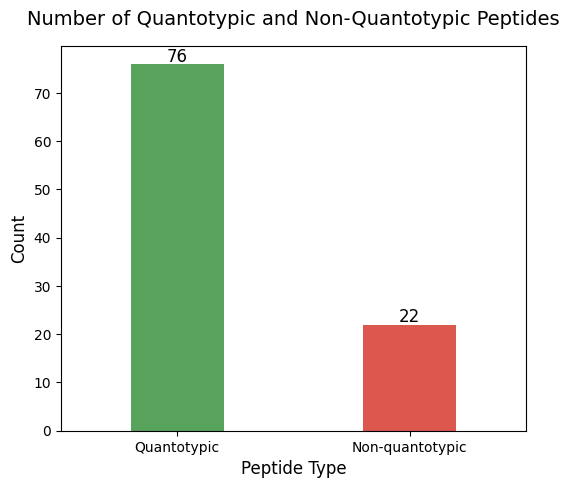

In [13]:
# Create a copy of the final status DataFrame
oversampled_df = PREMIDID.copy()

# Map "bon" to 0 and "mauvais" to 1 for binary classification
oversampled_df["quantotypic"] = oversampled_df["Status_PREMIDID"].map({"bon": 0, "mauvais": 1})

# Copy the oversampled data
data = oversampled_df.copy()

# Map 0 -> "Quantotypic" and 1 -> "Non-quantotypic" for better visualization
data["quantotypic"] = data["quantotypic"].map({0: "Quantotypic", 1: "Non-quantotypic"})

# Count the number of occurrences in each class
count_data = data["quantotypic"].value_counts()

# Create the bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=count_data.index, y=count_data.values, hue=count_data.index, 
            palette=["#4CAF50", "#F44336"], width=0.4, legend=False)

# Set axis labels and title
plt.xlabel("Peptide Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Quantotypic and Non-Quantotypic Peptides", fontsize=14, pad=15)

# Add value labels on top of each bar
for i, v in enumerate(count_data.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

# Save and show the figure
plt.savefig("Images/PREMIDID_number_quantotypic_non_quantotypic_peptides.png", bbox_inches='tight')
plt.show()

In [ ]:
set_premidid = set(PREMIDID["Peptide_PREMIDID"])
set_spare = set(SPARE["Peptide_SPARE"])

same_peptides = set_premidid.intersection(set_spare)
same_peptides_premidid = PREMIDID[PREMIDID["Peptide_PREMIDID"].isin(same_peptides)]
same_peptides_spare = SPARE[SPARE["Peptide_SPARE"].isin(same_peptides)]

status_comparison = pd.merge(same_peptides_premidid, same_peptides_spare, left_on="Peptide_PREMIDID", right_on="Peptide_SPARE", suffixes=('_PREMIDID', '_SPARE'))
same_bon_count = status_comparison[(status_comparison["Status_PREMIDID"] == "bon") & (status_comparison["Status_SPARE"] == "bon")].shape[0]
same_mauvais_count = status_comparison[(status_comparison["Status_PREMIDID"] == "mauvais") & (status_comparison["Status_SPARE"] == "mauvais")].shape[0]
diff_status_count = status_comparison[(status_comparison["Status_PREMIDID"] != status_comparison["Status_SPARE"])].shape[0]
print(f"Il y a {len(same_peptides)} peptides qui sont dans les deux dataset. Dont {same_bon_count} peptides quantotypic, {same_mauvais_count} peptides non-quantotypic et {diff_status_count} peptides avec un status différent.")

only_premidid = set_premidid - same_peptides
print(f"Il y a {len(only_premidid)} peptides qui sont uniquement dans le dataset PREDIMID.")

only_spare = set_spare - same_peptides
print(f"Il y a {len(only_spare)} peptides qui sont uniquement dans le dataset SPARE.")

Il y a 85 peptides qui sont dans les deux dataset. Dont 59 peptides quantotypic, 12 peptides non-quantotypic et 14 peptides avec un status différent.
Il y a 13 peptides qui sont uniquement dans le dataset PREDIMID.
Il y a 70 peptides qui sont uniquement dans le dataset SPARE.
